<font size="+3"><strong> Predicting Price with Area, Location, and Property type</strong></font>

In [114]:
import warnings
from glob import glob
from io import StringIO
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import string,re
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.linear_model import LinearRegression, Ridge  
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

In [87]:
df = pd.read_csv('properties.csv')

## Explore

In [88]:
print('Data shape is ' , df.shape)
df.info()

Data shape is  (11418, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418 entries, 0 to 11417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   type      11418 non-null  object
 1   title     11418 non-null  object
 2   location  11418 non-null  object
 3   bedroom   11418 non-null  object
 4   bathroom  11418 non-null  int64 
 5   size_sqm  11418 non-null  object
 6   price     11418 non-null  object
dtypes: int64(1), object(6)
memory usage: 624.5+ KB


In [89]:
df.head(10)

,type,title,location,bedroom,bathroom,size_sqm,price
0,Duplex,Prime Location Duplex Fully Finished With A\C,"Park View, North Investors Area, New Cairo Cit...",4,4,345,"6,850,000"
1,Villa,Town house resale at Mivida Emaar with best price,"Mivida, 5th Settlement Compounds, The 5th Sett...",3,3,285,"10,000,000"
2,Apartment,Lake View Residence - Apartment | Prime Location,"Lake View Residence, 5th Settlement Compounds,...",3,3,210,"5,700,000"
3,Townhouse,Best Penthouse for sale in villette ( sky conds ),"La Vista City, New Capital Compounds, New Capi...",4,4,230,"7,510,000"
4,Penthouse,2nd Floor | Fully Finished | Lowest Price |Par...,"Villette, 5th Settlement Compounds, The 5th Se...",5,6,284,"8,511,300"
5,Apartment,Amazing Delivered Villa Below market price at...,"Tag Sultan, Ring Road, Cairo",3,2,172,"3,150,000"
6,Villa,Under market Price Apart. In tag sultan for sale,"Cairo Festival City, North Investors Area, New...",5,4,250,"3,500,000"
7,Townhouse,Apartment with installments at Lake View Resid...,"Taj City, 5th Settlement Compounds, The 5th Se...",4,4,220,"6,100,000"
8,Apartment,0% DP over 9 y f.finished apartment for sale,"Tag Sultan, Ring Road, Cairo",2,2,114,"2,278,506"
9,Apartment,Villa Modern Hyde Park 327M under market price,"Lake View Residence, 5th Settlement Compounds,...",3,3,204,"4,112,700"


In [90]:
df.nunique()

type          10
title       9941
location     803
bedroom       10
bathroom       8
size_sqm     718
price       2497
dtype: int64

In [91]:
cdf=df.copy()
cdf.price.value_counts()

Ask           412
2,500,000     174
3,000,000     168
3,500,000     154
4,000,000     131
             ... 
18,500,001      1
1,247,000       1
6,558,000       1
2,372,031       1
4,554,066       1
Name: price, Length: 2497, dtype: int64

In [92]:
testingrows=cdf.loc[cdf.price=='Ask']
cdf=cdf.drop(cdf.loc[cdf.price=='Ask'].index,axis=0)
cdf

,type,title,location,bedroom,bathroom,size_sqm,price
0,Duplex,Prime Location Duplex Fully Finished With A\C,"Park View, North Investors Area, New Cairo Cit...",4,4,345,"6,850,000"
1,Villa,Town house resale at Mivida Emaar with best price,"Mivida, 5th Settlement Compounds, The 5th Sett...",3,3,285,"10,000,000"
2,Apartment,Lake View Residence - Apartment | Prime Location,"Lake View Residence, 5th Settlement Compounds,...",3,3,210,"5,700,000"
3,Townhouse,Best Penthouse for sale in villette ( sky conds ),"La Vista City, New Capital Compounds, New Capi...",4,4,230,"7,510,000"
4,Penthouse,2nd Floor | Fully Finished | Lowest Price |Par...,"Villette, 5th Settlement Compounds, The 5th Se...",5,6,284,"8,511,300"
...,...,...,...,...,...,...,...
11413,Villa,فيلا تشطيب الترا سوبر لوكس بالتجمع علي شارع رئ...,"Street70, District 2, The 5th Settlement, New ...",8,7,"1,500","30,000,000"
11414,Townhouse,town house for sale 220m Mountain View III,"Mountain View 3, 5th Settlement Compounds, The...",4,4,220,"10,276,891"
11415,Apartment,3 Bedrooms|Del 2026|5% Down|9 years install,"IL Bosco City, Mostakbal City Compounds, Mosta...",3,3,177,"2,811,346"
11416,Penthouse,Very prime location penthouse 275m for sale,"Stone Residence, 5th Settlement Compounds, The...",5,4,275,"3,000,000"


In [93]:
cdf['area_sqm'] = pd.to_numeric(cdf['size_sqm'], errors='coerce')

In [94]:
cdf['price_egp'] = cdf['price'].str.replace(',' , '').astype(float)

In [95]:
print('Data shape is ' , cdf.shape)
cdf.info()

Data shape is  (11006, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11006 entries, 0 to 11417
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       11006 non-null  object 
 1   title      11006 non-null  object 
 2   location   11006 non-null  object 
 3   bedroom    11006 non-null  object 
 4   bathroom   11006 non-null  int64  
 5   size_sqm   11006 non-null  object 
 6   price      11006 non-null  object 
 7   area_sqm   10707 non-null  float64
 8   price_egp  11006 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 859.8+ KB


In [96]:

cdf.drop(columns=['title' , 'bedroom' , 'bathroom', 'size_sqm' , 'price'] , inplace=True)
cdf['city'] = cdf['location'].str.split(',', expand=True)[2]
cdf.drop(columns='location' , inplace=True)
cdf['city'].str.strip().dropna()
cdf.dropna(inplace=True)
cdf.head()

,type,area_sqm,price_egp,city
0,Duplex,345.0,6850000.0,New Cairo City
1,Villa,285.0,10000000.0,The 5th Settlement
2,Apartment,210.0,5700000.0,The 5th Settlement
3,Townhouse,230.0,7510000.0,New Capital City
4,Penthouse,284.0,8511300.0,The 5th Settlement


In [97]:
print('Data shape is ' , cdf.shape)
cdf.info()

Data shape is  (10085, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10085 entries, 0 to 11417
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       10085 non-null  object 
 1   area_sqm   10085 non-null  float64
 2   price_egp  10085 non-null  float64
 3   city       10085 non-null  object 
dtypes: float64(2), object(2)
memory usage: 393.9+ KB


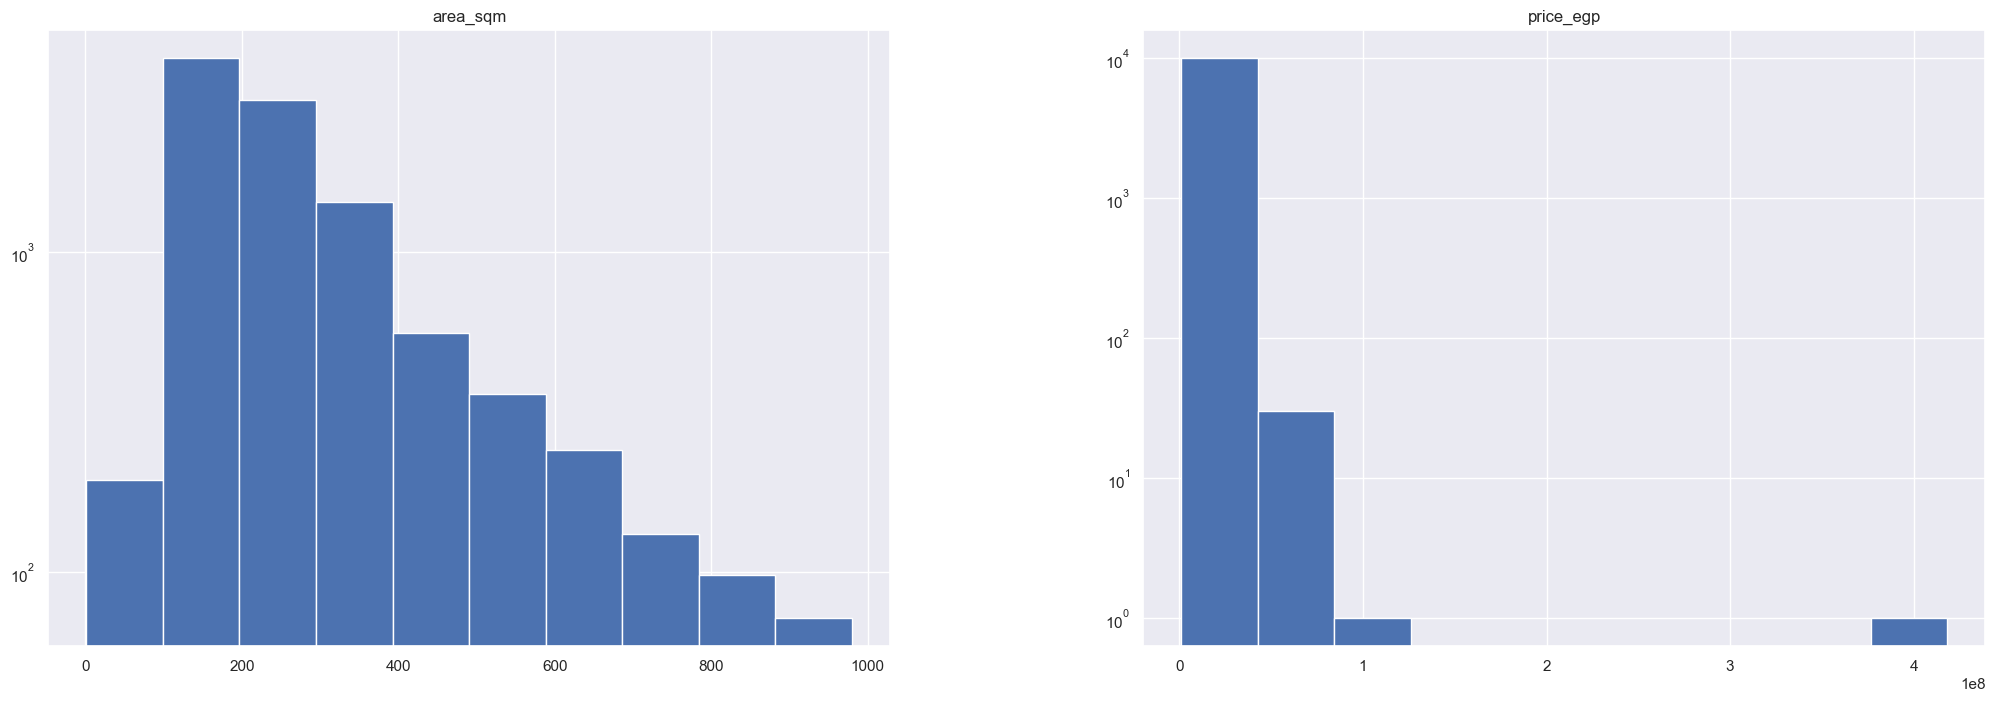

In [98]:
sns.set(rc={"figure.figsize":(25, 8)})
cdf.hist(log=1);

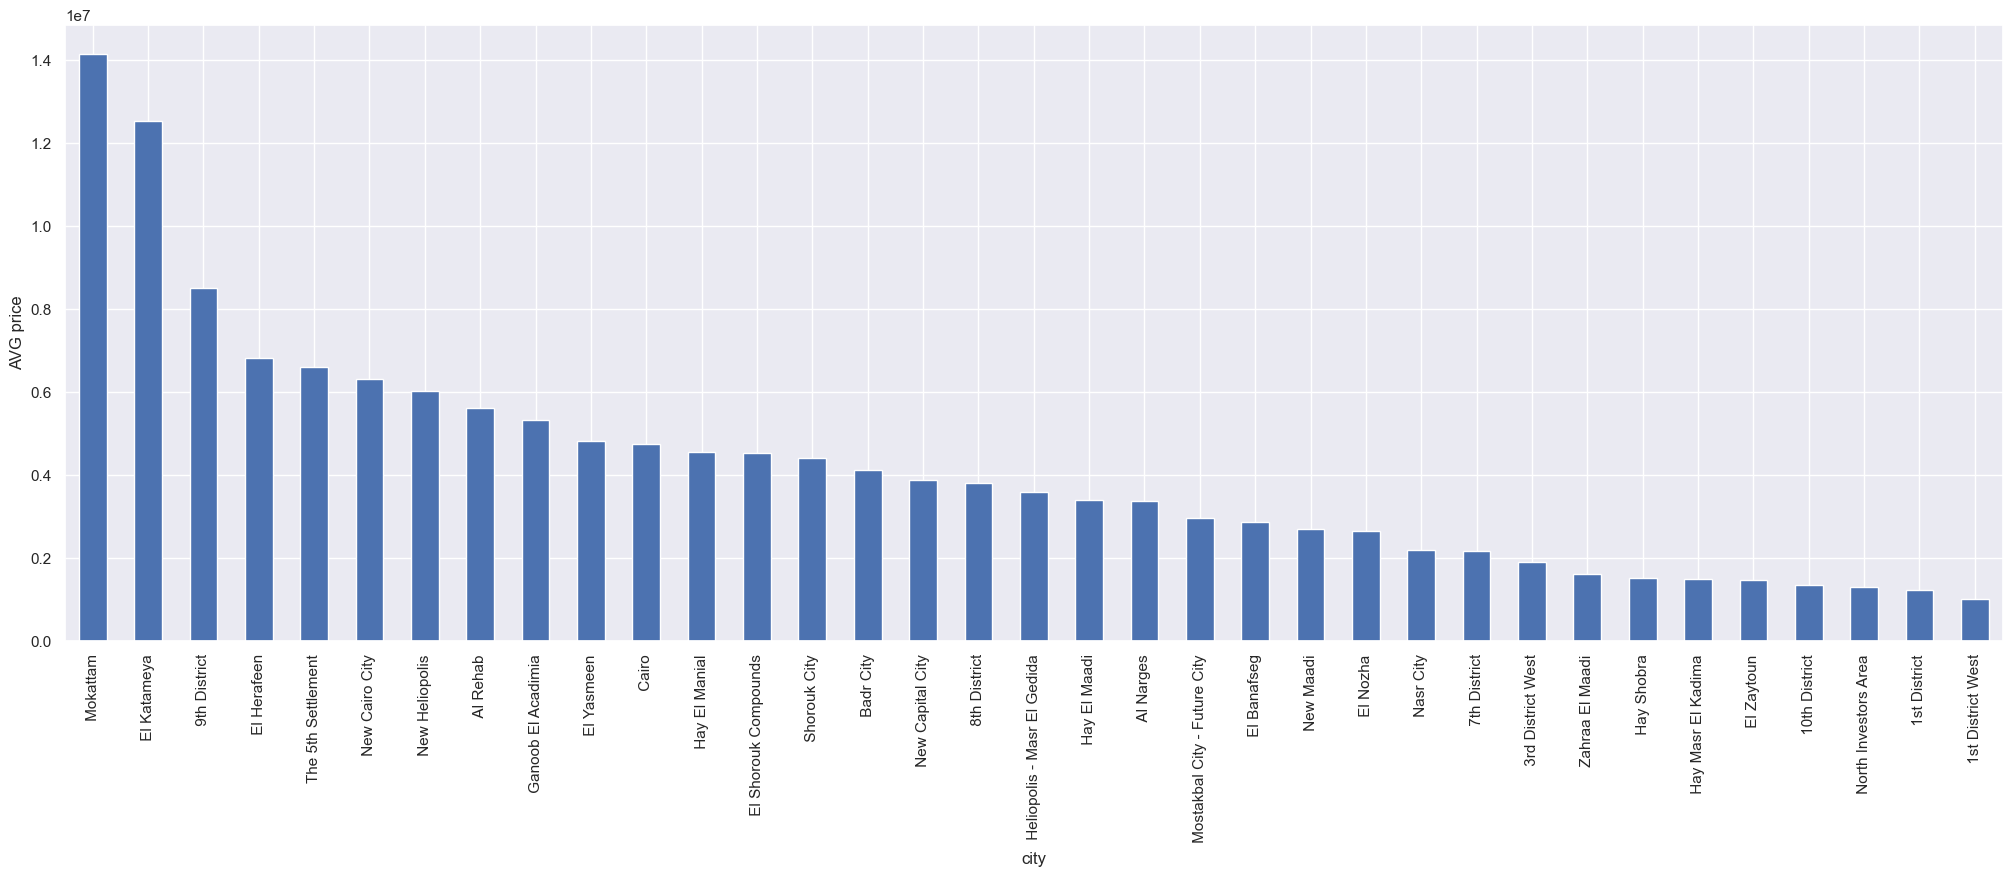

In [99]:
cities = cdf.groupby('city')['price_egp'].mean().sort_values(ascending=False)
cities.plot(kind='bar',
                         
                         xlabel='city',
                         ylabel='AVG price',
);

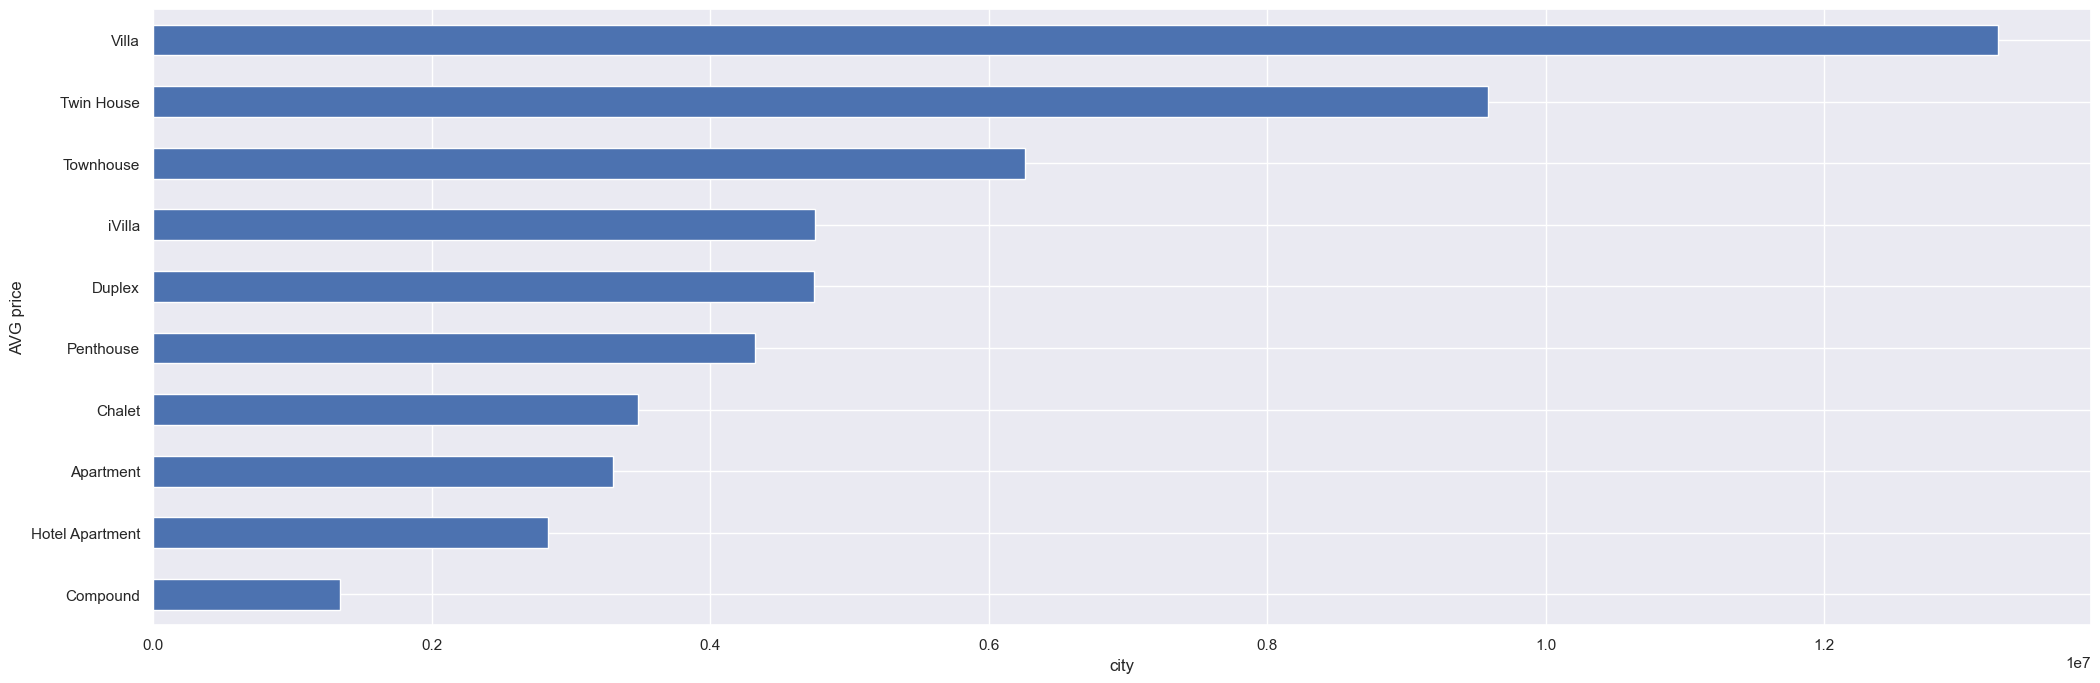

In [117]:
types = cdf.groupby('type')['price_egp'].mean().sort_values(ascending=True)
types.plot(kind='barh',
                         
                         xlabel='city',
                         ylabel='AVG price',
);

## Split

In [100]:
target = 'price_egp'
feature = ['area_sqm', 'city','type']
X_train = cdf[feature]
y_train = cdf[target]

# Build Model

## Baseline

In [101]:
y_mean = y_train.mean()
y_pred_traning = [y_mean] * len(y_train)
print("Mean apt price:", y_mean)
print("Baseline MAE:", mean_absolute_error(y_train , y_pred_traning))

Mean apt price: 6155540.683787804
Baseline MAE: 4158683.9519234556


 ## Iterate

In [102]:
model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
    
)
model.fit(X_train , y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['city', 'type'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## Evaluate

In [103]:
y_pred_traning = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train , y_pred_traning))

Training MAE: 2277437.3560858117


In [104]:
def make_prediction(area, city, type_):
    data = {
        'area_sqm' : area,
        'city' : city,
        'type' : type_
        }
    cdf = pd.DataFrame(data , index=[0])
    prediction = model.predict(cdf).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [105]:
make_prediction(200, 'New Capital City', 'Villa')

'Predicted apartment price: $5639536.49'

# Communicate Results

In [109]:
intercept = model.named_steps['ridge'].intercept_
coefficients = model.named_steps['ridge'].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 46
[  21744.44653198 1281331.46568517 2013308.9413197   564907.34025475
 1491700.67263285]


In [110]:
feature_names = model.named_steps['onehotencoder'].get_feature_names()
print("features len:", len(feature_names))
print(feature_names[:5])  # First five feature names

features len: 46
['area_sqm', 'city_1', 'city_2', 'city_3', 'city_4']


In [111]:
feat_imp = pd.Series(coefficients , index=feature_names)
feat_imp.head()

area_sqm    2.174445e+04
city_1      1.281331e+06
city_2      2.013309e+06
city_3      5.649073e+05
city_4      1.491701e+06
dtype: float64

In [112]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = -1295535.06
+ (21744.45 * area_sqm)
+ (1281331.47 * city_1)
+ (2013308.94 * city_2)
+ (564907.34 * city_3)
+ (1491700.67 * city_4)
+ (566181.68 * city_5)
+ (160460.6 * city_6)
+ (388416.7 * city_7)
+ (2652903.99 * city_8)
+ (529776.52 * city_9)
+ (-261354.81 * city_10)
+ (7531110.69 * city_11)
+ (519442.57 * city_12)
+ (-635189.37 * city_13)
+ (394495.42 * city_14)
+ (-496797.14 * city_15)
+ (761526.78 * city_16)
+ (-376057.15 * city_17)
+ (-4766935.51 * city_18)
+ (100846.98 * city_19)
+ (-2067625.57 * city_20)
+ (-596540.1 * city_21)
+ (-92720.78 * city_22)
+ (-98085.57 * city_23)
+ (-2008082.29 * city_24)
+ (1573956.03 * city_25)
+ (-810486.81 * city_26)
+ (-42720.78 * city_27)
+ (-84479.55 * city_28)
+ (2251751.4 * city_29)
+ (-4662024.17 * city_30)
+ (-352731.98 * city_31)
+ (-741859.76 * city_32)
+ (-1032881.6 * city_33)
+ (-17720.78 * city_34)
+ (-3637824.06 * city_35)
+ (-1742408.29 * type_1)
+ (2586182.24 * type_2)
+ (-756857.06 * type_3)
+ (188897.34 * type_4)
+ (-107

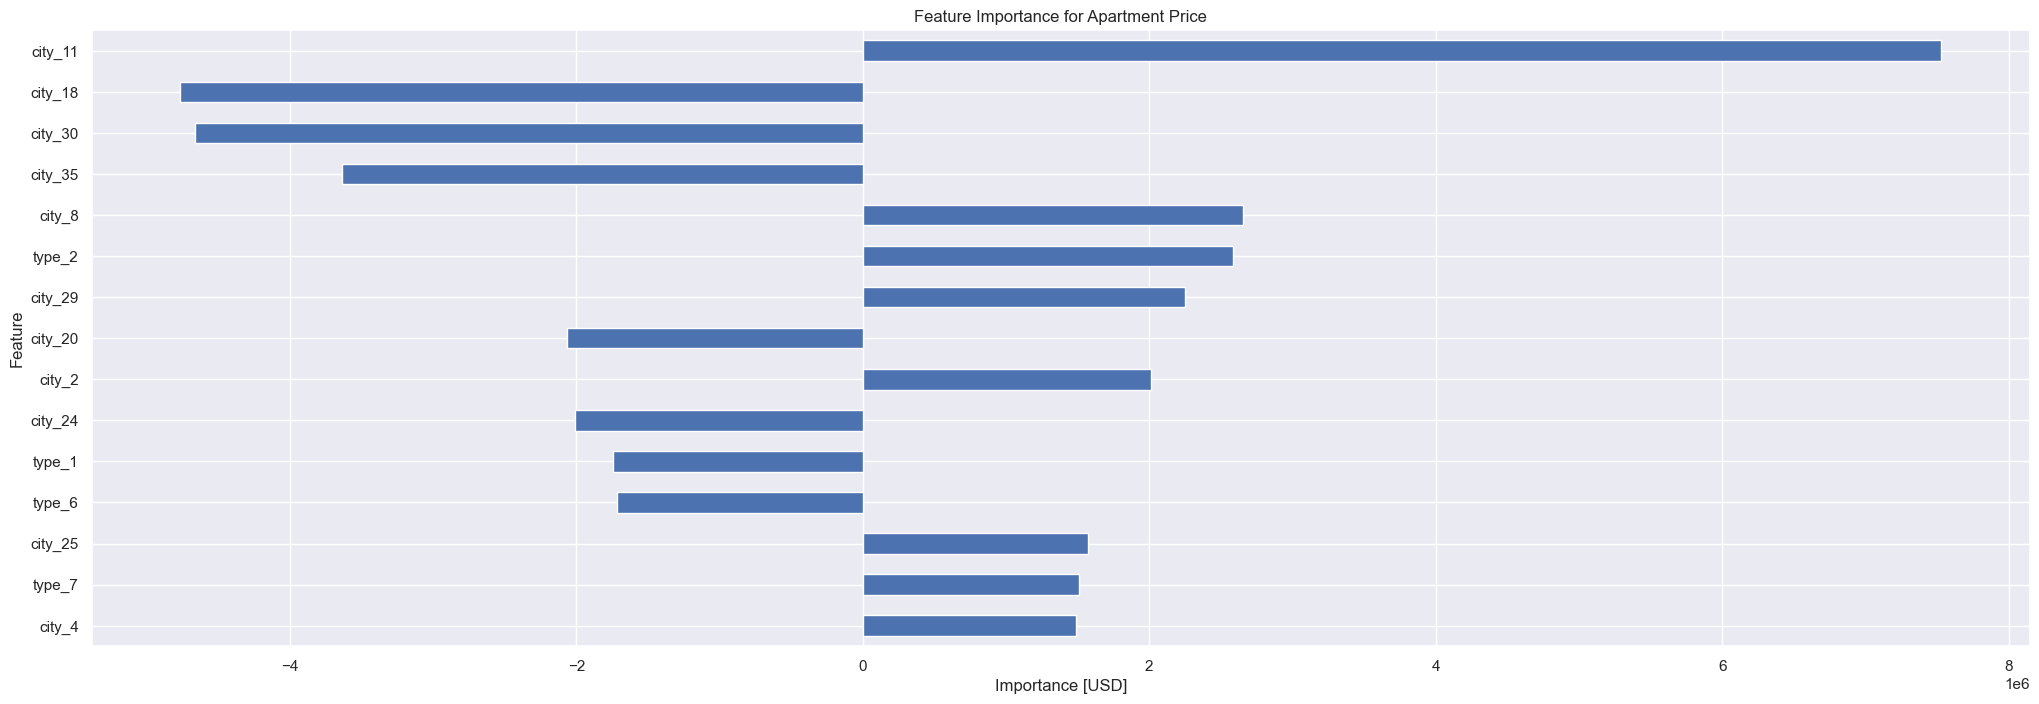

In [115]:
feat_imp.sort_values(key=abs).tail(15).plot(kind='barh')
plt.xlabel('Importance [USD]')
plt.ylabel('Feature')
plt.title('Feature Importance for Apartment Price');